In [1]:
import sys
sys.path.insert(0,'C:\\code\\python_for_the_financial_economist\\')

"""
Magic commands
"""

%load_ext autoreload
%autoreload 2

"""
Load relevant packages
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib import animation, cm
import seaborn as sns
import datetime
from scipy import stats
from scipy import optimize

from pandas_datareader.data import DataReader
from pandas_datareader.famafrench import FamaFrenchReader, get_available_datasets

from statsmodels.tools.numdiff import approx_fprime, approx_hess

from typing import Union, List

"""
Own packages
"""
from codelib.dal.fred_yield_data import get_nominal_yield_data

from codelib.visualization.base import correlation_plot
from codelib.visualization.layout import DefaultStyle
DefaultStyle();

# Exercises - Week 5

In this week we will look at a few exercises that 



## Problem 1: Recession forecasting 

__Note:__ We follow the exposition of [Nyberg (2010)](https://onlinelibrary-wiley-com.esc-web.lib.cbs.dk:8443/doi/abs/10.1002/for.1161)

In this exercise, we will explore a simple model for forecasting US recessions. Among other things, we will look at the evidence for the yield spread being a predictor of recessions as often mentioned in financial news (and the academic literature). 

We are interested in prediciting the recession indicator $y_t, \; t=1,..., T$ which is a binary dependent variable that is defined by

$$
y_t = \left\{ \begin{matrix}
                1, & \text{if the economy is in a recessionary state at time } t \\ 
                0, & \text{if the economy is in a expansionary state at time } t
              \end{matrix}  \right.
$$

The probability of the dependent variable taking the value $1$ is given by $p_t$ specified as 

$$
p_t = \text{Prob}_{t-1}[y_t = 1] = \Phi(\pi_{t})
$$

where $\Phi()$ is the cdf of a standard normal. $\pi_{t}$ is included in the information set at time $t-1$. This model is known as a [Probit model](https://en.wikipedia.org/wiki/Probit_model). 

A model not taking the dynamic structure into account is given by the static formulation ($k \leq 1$ must be larger than the forecast horizon) 

$$
\pi_{t} = \mathbf{x}_{t-k}^\top \beta
$$

A dynamic structure can be implemented as ($l \leq 1$)

$$
\pi_{t} = \mathbf{x}_{t-k}^\top \beta + \delta y_{t-l}
$$

A dynamic autoregressive model can be implemented as 

$$
\pi_{t} = \mathbf{x}_{t-k}^\top \beta + \delta y_{t-l} + \alpha \pi_{t-1}
$$

__Question 1__

Get recession indicators ('USREC') and yield spread ('T10YFF') from the FRED database from the beginning of 1983. Plot the yield spread together with the recession indicators. 

__Question 2__

First, we will consider a model where we solely use the yield spread (and a constant) to predict recessions. To that end, we need to define the likelihood function. 

The conditional probability function is given by

$$
f_{Y_t}(y_t \vert \mathbf{x}_t, \mathbf{x}_{t-1},..., y_{t-1},...; \theta)   = p_t^{y_t} (1 - p_t)^{1 - y_t} = \Phi(\pi_{t})^{y_t} (1 - \Phi(\pi_{t}))^{1 - y_t}
$$

We can therefore write the (conditional) likelihood function as 

$$
L_T(\theta) = \prod_{t=1}^T \Phi(\pi_{t})^{y_t} (1 - \Phi(\pi_{t}))^{1 - y_t}
$$


and the log-likelihood function as 

$$
\mathcal{L}_{T}(\theta) = \sum_{t=1}^T q_t(y_t, \mathbf{x}_t; \theta) = \sum_{t=1}^T \left[y_t \ln \Phi(\pi_{t}) + (1-y_t) \ln (1 - \Phi(\pi_{t}))  \right]
$$

Assume that $\pi_{t} = \mathbf{x}_{t-k}^\top \beta$ with $\mathbf{x}_{t-k} = [1, ys_{t-k}]^\top$ where $ys_{t}$ is the yield-spread at time $t$. Consider $k=6$. Estimate the model using maximum-likelihood. 


__Question 3__

Derive the expressions for

$$
\begin{align}
\frac{1}{n} \sum_{i=1}^n  \frac{\partial^2 q_t(y_t, \mathbf{x}_t; \theta)}{\partial \theta \partial \theta^\top}  \\
\frac{1}{n} \sum_{i=1}^n \frac{\partial q_t(y_t, \mathbf{x}_t; \theta)}{\partial \theta } \frac{\partial q_t(y_t, \mathbf{x}_t; \theta)}{\partial \theta^\top }  
\end{align}
$$
when considering the static model. It may be usefull to remember that 

$$
\frac{\partial \Phi(\pi_t)}{\partial \theta} = \phi(\pi_t) \frac{\partial \pi_t}{\partial \theta}  = \phi(\pi_t) \mathbf{x}_{t-k}
$$

where $\phi(\pi_t)$ is the density of a standard normal and 

$$
\frac{\partial \phi(\pi_t)}{\partial \theta} = -\phi(\pi_t) \pi_t \frac{\partial \pi_t}{\partial \theta}
$$

Implement functions that calculate these quantities. 

__Question 4__

Calculate the standard errors analytically and numerically. 

__Quesiton 5__

Check the results using `statsmodels`. Are the parameters significant at a 5\% significance level?

__Question 6__

Implement and estimate the dynamic model.

$$
\pi_{t} = \mathbf{x}_{t-k}^\top \beta + \delta y_{t-l}
$$

__Question 7__

Implement and estimate the autoregressive model.

$$
\pi_{t} = \mathbf{x}_{t-k}^\top \beta  + \alpha \pi_{t-1}
$$

__Note:__ We have only considered in-sample results which may not work out-of-sample. 

### Solution

__Question 1__


In [2]:
df_data = DataReader(['USREC', 'T10YFF', 'T10Y3M'], 'fred', start=datetime.date(1983,1,1))

In [3]:
df_data

,USREC,T10YFF,T10Y3M
DATE,,,
1983-01-01,0.0,NaN,NaN
1983-01-03,NaN,1.13,2.15
1983-01-04,NaN,0.90,2.09
1983-01-05,NaN,1.89,2.10
1983-01-06,NaN,1.91,2.19
...,...,...,...
2021-09-01,NaN,1.23,1.26
2021-09-02,NaN,1.21,1.24
2021-09-03,NaN,1.25,1.28


In [4]:
df_data_monthly = df_data.resample('M').first().dropna()
df_data_monthly.index = df_data['USREC'].dropna().index

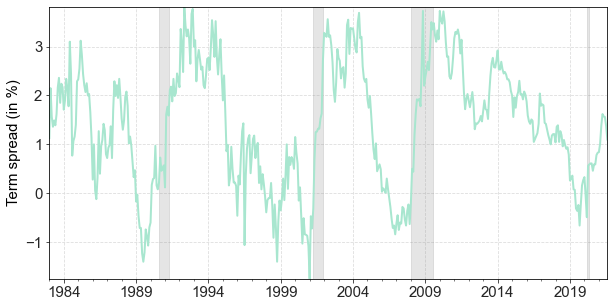

In [5]:
nber_recessions = df_data_monthly['USREC'].dropna()

# get start and end dates of recessions
change_nber = nber_recessions - nber_recessions.shift(1)
start_dates = change_nber[change_nber==1.0].index.to_list()
end_dates = change_nber[change_nber==-1.0].index.to_list()

ax = df_data_monthly['T10YFF'].plot(figsize=(10,5));
ax.set_ylabel('Term spread (in %)');
ax.set_xlabel('');
for s, e in zip(start_dates, end_dates):
    ax.axvspan(s, e, color="grey", alpha=0.2)

__Question 2__

First, we implement the log-likelihood function 

In [6]:
"""
Log-likelihood function 
"""

def log_like_probit(beta, y, x, individual=False): 
    
    pi = x @ beta
    prob = stats.norm.cdf(pi)
    
    log_like = y * np.log(prob) + (1-y) * np.log(1 - prob)
    
    if individual: 
        return -log_like
    else:
        return -np.sum(log_like)

Next, we select the data which we want to use

In [7]:
k = 6
y_data = df_data_monthly['USREC'].values[k:]
x_data = df_data_monthly['T10YFF'].values[:-k] / 100
x_data = np.c_[np.ones_like(x_data), x_data]

In [8]:
"""
Minimize negative log-likelihood 
"""
res = optimize.minimize(log_like_probit, [0.13,0.0], args=(y_data, x_data))
res

      fun: 112.35680094433553
 hess_inv: array([[ 1.19285254e-02, -4.65467622e-01],
       [-4.65467622e-01,  6.04394357e+01]])
      jac: array([3.81469727e-06, 0.00000000e+00])
  message: 'Optimization terminated successfully.'
     nfev: 45
      nit: 14
     njev: 15
   status: 0
  success: True
        x: array([ -1.02870448, -38.19343503])

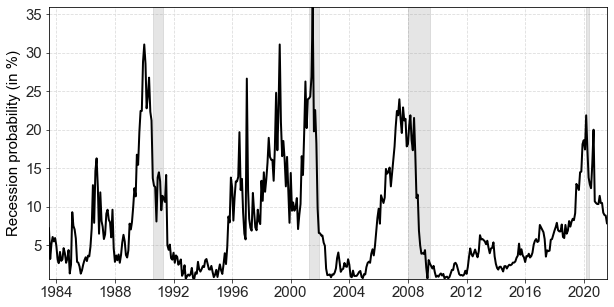

In [9]:
fig, ax = plt.subplots(figsize=(10,5))

ax.plot(df_data_monthly['USREC'].index[k:].values, stats.norm.cdf(x_data @ res.x) * 100, color="black")

# get start and end dates of recessions
change_nber = nber_recessions - nber_recessions.shift(1)
start_dates = change_nber[change_nber==1.0].index.to_list()
end_dates = change_nber[change_nber==-1.0].index.to_list()

ax.set_ylabel('Recession probability (in %)');
ax.set_xlabel('');
for s, e in zip(start_dates, end_dates):
    ax.axvspan(s, e, color="grey", alpha=0.2)
    

__Question 3__

We note that 

$$
q_t(y_t, \mathbf{x}_t; \theta) = y_t \ln \Phi(\pi_{t}) + (1-y_t) \ln (1 - \Phi(\pi_{t}))
$$

First, we find the gradient (using the chain-rule, derivative of natural logarithm, fundamental theorem of calculus, etc.)

$$
\begin{align}
\frac{\partial q_t(y_t, \mathbf{x}_t; \theta)}{\partial \theta} &= \left[y_t \frac{1}{\Phi(\pi_{t})} - (1-y_t) \frac{1}{1 -\Phi(\pi_{t})} \right] \frac{\partial \Phi(\pi_{t})}{\partial \theta}\\
&= \left[y_t \frac{1}{\Phi(\pi_{t})} - (1-y_t) \frac{1}{1 -\Phi(\pi_{t})} \right] \phi(\pi_{t})\frac{\partial \pi_{t}}{\partial \theta} \\
&= \left[y_t \frac{1}{\Phi(\pi_{t})} - (1-y_t) \frac{1}{1 -\Phi(\pi_{t})} \right] \phi(\pi_{t})\mathbf{x}_t
\end{align}
$$

Implying that 

$$
\begin{align}
\frac{1}{n} \sum_{i=1}^n \frac{\partial q_t(y_t, \mathbf{x}_t; \theta)}{\partial \theta } \frac{\partial q_t(y_t, \mathbf{x}_t; \theta)}{\partial \theta^\top }  = \frac{1}{n} \sum_{i=1}^n \left[y_t \frac{1}{\Phi(\pi_{t})} - (1-y_t) \frac{1}{1 -\Phi(\pi_{t})} \right]^2 \phi(\pi_{t})^2\mathbf{x}_t\mathbf{x}_t^\top
\end{align}
$$

The Hessian is given by 

$$
\begin{align}
\frac{\partial^2 q_t(y_t, \mathbf{x}_t; \theta)}{\partial \theta \partial \theta^\top} &= \frac{\partial}{\partial \theta}\left[y_t \frac{1}{\Phi(\pi_{t})} - (1-y_t) \frac{1}{1 -\Phi(\pi_{t})} \right] \phi(\pi_{t})\mathbf{x}_t^\top \\
&= \left[\frac{\partial}{\partial \theta}\left[y_t \frac{1}{\Phi(\pi_{t})} - (1-y_t) \frac{1}{1 -\Phi(\pi_{t})} \right] \phi(\pi_{t})\mathbf{x}_t^\top \right] + \left[y_t \frac{1}{\Phi(\pi_{t})} - (1-y_t) \frac{1}{1 -\Phi(\pi_{t})} \right] \frac{\partial}{\partial \theta}\phi(\pi_{t})\mathbf{x}_t^\top \\
&=\left[-y_t \frac{1}{\Phi(\pi_{t})^2} - (1-y_t) \frac{1}{(1 -\Phi(\pi_{t}))^2} \right] \phi(\pi_{t})\mathbf{x}_t\phi(\pi_{t})\mathbf{x}_t^\top - \left[y_t \frac{1}{\Phi(\pi_{t})} - (1-y_t) \frac{1}{1 -\Phi(\pi_{t})} \right]  \phi(\pi_{t}) \mathbf{x}_t^\top \beta \mathbf{x}_t \mathbf{x}_t^\top \\
&=-\left[y_t \frac{\phi(\pi_{t}) + \mathbf{x}_t^\top \beta \Phi(\pi_{t})}{\Phi(\pi_{t})^2} + (1-y_t) \frac{\phi(\pi_{t}) - (1 -\Phi(\pi_{t}))\mathbf{x}_t^\top \beta}{(\phi(\pi_{t}) -\Phi(\pi_{t}))^2} \right] \phi(\pi_{t})\mathbf{x}_t\mathbf{x}_t^\top 
\end{align}
$$

Below, we implement the expressions. 

In [10]:
"""
Gradient (outer product of the scores)
"""

def outer_gradient(theta, x, y): 
    
    pi = x @ theta 
    pdf_vals = stats.norm.pdf(pi)
    cdf_vals = stats.norm.cdf(pi)
    
    first_part = (y * (1 / cdf_vals) - (1 - y) * (1 / (1-cdf_vals)))**2 * pdf_vals**2
    
    return np.sum(first_part[:, None, None] * np.einsum('ji,jk->jik',x, x), axis=0)
    

"""
Hessian 
"""

def hessian(theta, x, y): 
    
    pi = x @ theta 
    pdf_vals = stats.norm.pdf(pi)
    cdf_vals = stats.norm.cdf(pi)
    
    first_part = (-(y * (pdf_vals + pi * cdf_vals) / (cdf_vals**2) + 
                   (1 - y) * (pdf_vals - pi * (1 - cdf_vals)) / ((1-cdf_vals)**2)) * pdf_vals)
    
    return np.sum(first_part[:, None, None] * np.einsum('ji,jk->jik',x, x), axis=0)

__Question 5__

In [11]:
params_mle = res.x
A = hessian(params_mle, x_data, y_data)
B = outer_gradient(params_mle, x_data, y_data)

param_mle_cov_A = np.linalg.inv(-A)

param_mle_cov_B = np.linalg.inv(B)

param_mle_cov_sandwich = np.linalg.inv(A) @ B @ np.linalg.inv(A)

In [12]:
# covariance matrix based on A
param_mle_cov_A

array([[ 1.19303469e-02, -4.65037620e-01],
       [-4.65037620e-01,  6.07593131e+01]])

In [13]:
# covariance matrix based on B
param_mle_cov_B

array([[ 1.17326359e-02, -4.05530442e-01],
       [-4.05530442e-01,  4.89219409e+01]])

In [14]:
# covariance matrix based on A^{-1}BA^{-1} "Sandwich formula"
param_mle_cov_sandwich

array([[ 1.22108764e-02, -5.40306898e-01],
       [-5.40306898e-01,  7.56390532e+01]])

In [15]:
# sandwich standard errors 
np.sqrt(np.diag(param_mle_cov_sandwich))

array([0.11050283, 8.69707153])

In [16]:
"""
Numerical scores
"""

scores = approx_fprime(params_mle, log_like_probit, args=(y_data, x_data, True))
B_approx = scores.T @ scores 

A_approx = -approx_hess(params_mle, log_like_probit, args=(y_data, x_data))

param_mle_cov_A_num = np.linalg.inv(-A_approx)

param_mle_cov_B_num = np.linalg.inv(B_approx)

param_mle_cov_sandwich_num = np.linalg.inv(A_approx) @ B_approx @ np.linalg.inv(A_approx)

In [17]:
# covariance matrix based on A
param_mle_cov_A_num

array([[ 1.19303469e-02, -4.65037615e-01],
       [-4.65037615e-01,  6.07593127e+01]])

In [18]:
# covariance matrix based on B
param_mle_cov_B_num

array([[ 1.17326358e-02, -4.05530432e-01],
       [-4.05530432e-01,  4.89219403e+01]])

In [19]:
# covariance matrix based on A^{-1}BA^{-1} "Sandwich formula"
param_mle_cov_sandwich_num

array([[ 1.22108764e-02, -5.40306899e-01],
       [-5.40306899e-01,  7.56390531e+01]])

In [20]:
# sandwich standard errors 
np.sqrt(np.diag(param_mle_cov_sandwich_num))

array([0.11050283, 8.69707152])

__Question 6__

Yes, both the constant and the term spread is highly signficant. 

Luckily, we get the same results as `statsmodels`. 

In [21]:
import statsmodels.api as sm

stat_est = sm.Probit(y_data, x_data).fit(cov_type='HC0')
stat_est.summary()

Optimization terminated successfully.
         Current function value: 0.245321
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                          Probit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  458
Model:                         Probit   Df Residuals:                      456
Method:                           MLE   Df Model:                            1
Date:                Wed, 08 Sep 2021   Pseudo R-squ.:                  0.1090
Time:                        20:23:10   Log-Likelihood:                -112.36
converged:                       True   LL-Null:                       -126.11
Covariance Type:                  HC0   LLR p-value:                 1.570e-07
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.0287      0.111     -9.309      0.000      -1.245      -0.812
x1           -38.1934      8.697     -4.392      0.000     -55.239     -21.147
==============================================================================
"""

__Question 6__

In [22]:
x_dynamic_data = np.c_[x_data, df_data_monthly['USREC'].values[k-1:-1]]

In [23]:
res_dynamic = optimize.minimize(log_like_probit, [0.0,0.0, 0.0], args=(y_data, x_dynamic_data))
res_dynamic

      fun: 30.00828211527152
 hess_inv: array([[ 4.50285188e-02, -3.66861429e-01, -4.10175011e-02],
       [-3.66861429e-01,  2.81212366e+02, -2.79431895e+00],
       [-4.10175011e-02, -2.79431895e+00,  1.58113400e-01]])
      jac: array([-2.86102295e-06,  0.00000000e+00,  7.39097595e-06])
  message: 'Optimization terminated successfully.'
     nfev: 96
      nit: 21
     njev: 24
   status: 0
  success: True
        x: array([ -2.03242502, -46.8434221 ,   3.65960003])

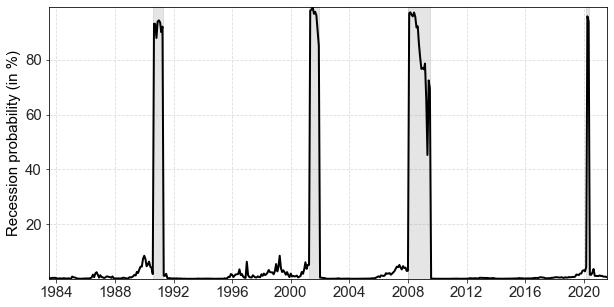

In [24]:
fig, ax = plt.subplots(figsize=(10,5))

ax.plot(df_data_monthly['USREC'].index[k:].values, stats.norm.cdf(x_dynamic_data @ res_dynamic.x) * 100, color="black")

# get start and end dates of recessions
change_nber = nber_recessions - nber_recessions.shift(1)
start_dates = change_nber[change_nber==1.0].index.to_list()
end_dates = change_nber[change_nber==-1.0].index.to_list()

ax.set_ylabel('Recession probability (in %)');
ax.set_xlabel('');
for s, e in zip(start_dates, end_dates):
    ax.axvspan(s, e, color="grey", alpha=0.2)
    

__Question 7__

In [25]:
"""
Log-likelihood function 
"""

def calculate_recession_probs(theta, x): 
    
    beta = theta[:-1]
    alpha = theta[-1]
    
    pi = x @ beta
    for i in range(1, len(x)):
        pi[i] += alpha * pi[i-1]
        
    prob = stats.norm.cdf(pi)
    return prob

def log_like_autoregressiv_probit(theta, y, x, individual=False): 
        
    prob = calculate_recession_probs(theta, x)
    
    log_like = y * np.log(prob) + (1-y) * np.log(1 - prob)
    
    if individual: 
        return -log_like
    else:
        return -np.sum(log_like)
    

In [26]:
res_auto = optimize.minimize(log_like_autoregressiv_probit, [0.1, -0.2, 0.9],
                             args=(y_data, x_data), bounds = ((None, None), (None, None),(0.0, 0.99)))
res_auto

      fun: 71.87557012160943
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-9.16600129e-04, -5.68434142e-06,  1.25908172e-03])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 152
      nit: 29
     njev: 38
   status: 0
  success: True
        x: array([ 5.88032993e-03, -1.41943658e+01,  9.36830412e-01])

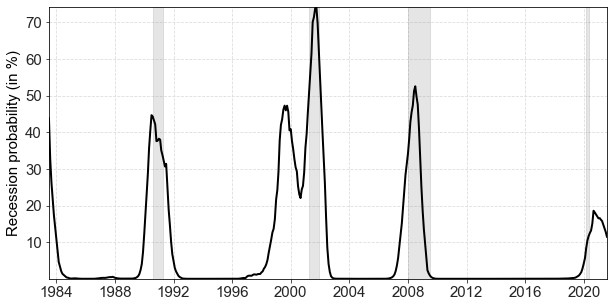

In [27]:
fig, ax = plt.subplots(figsize=(10,5))

ax.plot(df_data_monthly['USREC'].index[k:].values, calculate_recession_probs(res_auto.x, x_data) * 100, color="black")

# get start and end dates of recessions
change_nber = nber_recessions - nber_recessions.shift(1)
start_dates = change_nber[change_nber==1.0].index.to_list()
end_dates = change_nber[change_nber==-1.0].index.to_list()

ax.set_ylabel('Recession probability (in %)');
ax.set_xlabel('');
for s, e in zip(start_dates, end_dates):
    ax.axvspan(s, e, color="grey", alpha=0.2)

## Problem 2: MLE and hypothesis testing 

Consider the [Gamma distribution](https://en.wikipedia.org/wiki/Gamma_distribution) 

$$
f_{y}(y; \theta) = \frac{\beta^\rho}{\Gamma(\rho)} y^{\rho -1} e^{-y \beta}
$$
where $\theta = (\beta, \rho)^\top$, $\Gamma(\rho)$ is the [gamma function](https://en.wikipedia.org/wiki/Gamma_function). 

__Question 1__

Simulate 1,000 observations assuming $\beta = 1$ and $\rho=1$ from a gamma distribution. Plot the histogram together with the true density. 

__Question 2__

Define the log-likelihood function and estimate the parameters. Note the functions `scipy.special.gamma`, `scipy.special.gammaln`, and `scipy.special.psi` may be relevant. 

__Question 3__

The gradiant is given by 

$$
 \frac{\partial q_i(y_i ;\theta)}{\partial \theta } = \begin{bmatrix} \rho \frac{1}{\beta} - y_i \\ \ln \beta - \frac{\partial \ln \Gamma (\rho)}{\partial \rho} + \ln y_i\end{bmatrix}\\
$$

and the Hessian is given by 



__Question XX__


Simulating the size and power properties 


### Solution 

__Question 1__

In [28]:
n = 1000
beta_true = 1.0
rho_true = 1.0
y_data = stats.gamma.rvs(a=rho_true, scale=1.0/beta_true, size=n)

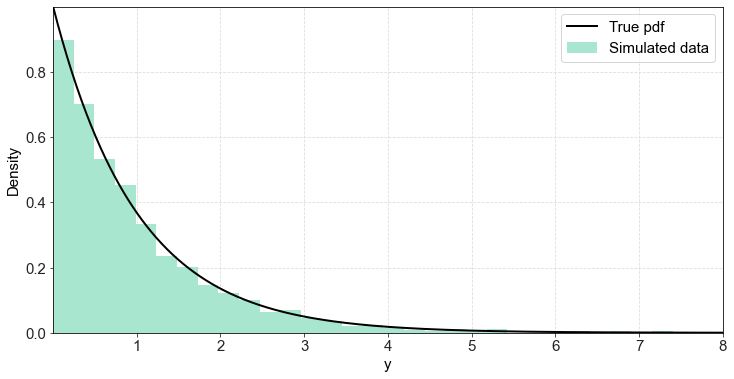

In [35]:
# density
y_vals = np.linspace(0.001, 8.0, 1000)
pdf_vals = stats.gamma.pdf(y_vals, a=rho_true, scale=1.0/beta_true)

# plotting 
fig, ax = plt.subplots(figsize=(12,6))

ax.hist(y_data, bins=30, density=True, label="Simulated data")
ax.plot(y_vals, pdf_vals, color="black", label="True pdf")

ax.set_xlabel("y")
ax.set_ylabel("Density")
ax.legend();

__Question 2__

The likelihood function can be written as 

$$
L_n(\theta) = \prod_{i=1}^n \frac{\beta^\rho}{\Gamma(\rho)} y_i^{\rho -1} e^{-y_i \beta}
$$

Taking the natural logarithm yields

$$
\mathcal{L}_{n}(\theta) = \sum_{i=1}^n q_i(y_i; \theta) = \sum_{i=1}^n \left[\rho \ln \beta - \ln \Gamma (\rho) + (\rho - 1) \ln y_i - y_i \beta \right] = n \left[\rho \ln \beta - \ln \Gamma (\rho) \right] + \sum_{i=1}^n \left[(\rho - 1) \ln y_i - y_i \beta \right]
$$



In [42]:
from scipy.special import gamma, gammaln, psi

"""
Define log-likelihood 
"""

def log_like_gamma(theta, y,  individual=False):
    
    beta = theta[0]
    rho = theta[1]
    
    log_like = rho * np.log(beta) - gammaln(rho) + (rho - 1) * np.log(y) - y * beta
    
    if individual: 
        return -log_like
    else:
        return -np.sum(log_like)
    

"""
Minimize negative log-like 
"""
res = optimize.minimize(log_like_gamma, [0.8, 0.8], args=(y_data, ))
res.x

array([1.01498944, 1.00214764])

__Question 3__




## Problem 3: Shrinkage estimators

# References


## Articles

[Nyberg (2010)](https://onlinelibrary-wiley-com.esc-web.lib.cbs.dk:8443/doi/abs/10.1002/for.1161)


## Books